Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - binary_io_u_3: 0.0271 - loss: 0.1857 - val_binary_io_u_3: 0.0000e+00 - val_loss: 0.1893
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - binary_io_u_3: 0.9313 - loss: 0.0203 - val_binary_io_u_3: 0.0000e+00 - val_loss: 0.0386
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - binary_io_u_3: 0.9187 - loss: 0.0201 - val_binary_io_u_3: 0.9032 - val_loss: 0.0198
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - binary_io_u_3: 0.9153 - loss: 0.0195 - val_binary_io_u_3: 0.9047 - val_loss: 0.0194
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - binary_io_u_3: 0.9129 - loss: 0.0196 - val_binary_io_u_3: 0.8986 - val_loss: 0.0192
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - binary_io_u_3: 0.9099 - loss: 0.0185 - val_binary_io_u_3: 0.8883 - val_loss: 0.0192
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - binary_io_u_3: 0.9038 - loss: 0.0183 - val_binary_io_u_3: 0.8758 - val_loss: 0.0195
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - bina

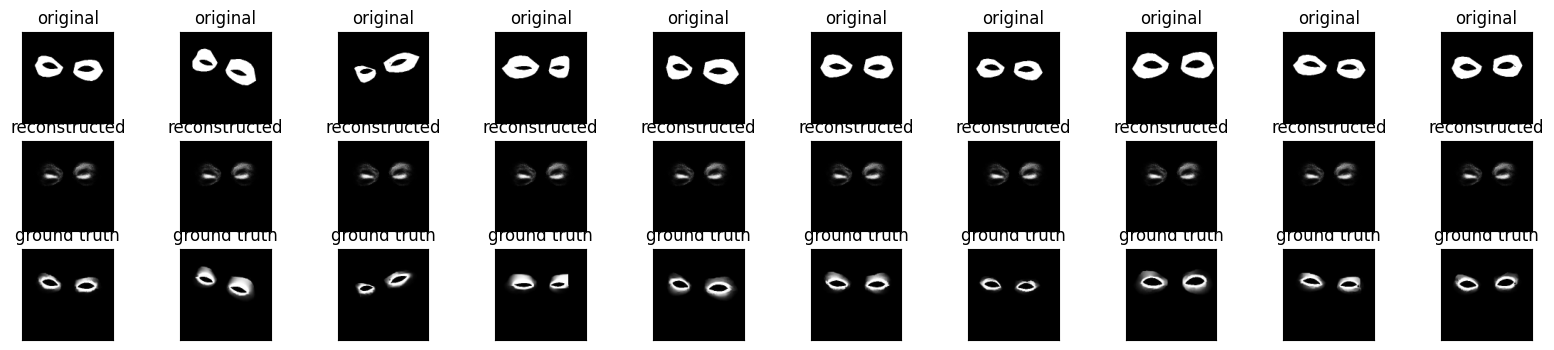

In [23]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses, Model,metrics
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import cv2

# 設定資料夾路徑
allblackwhite_dir = '../allblackwhite'
pymatting_outcome_rw_dir = '../pymatting_outcome_rw'

# 讀取圖片和標籤
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, (128, 128))
            images.append(img_resized)
    return np.array(images)

x = load_images_from_folder(allblackwhite_dir)
y = load_images_from_folder(pymatting_outcome_rw_dir)

# 資料分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# 重塑圖片維度
x_train = x_train.reshape((x_train.shape[0], 128, 128, 1))
y_train = y_train.reshape((y_train.shape[0], 128, 128, 1))
x_test = x_test.reshape((x_test.shape[0], 128, 128, 1))
y_test = y_test.reshape((y_test.shape[0], 128, 128, 1))

# 標準化圖片 
x_train = x_train.astype('float32') / 255.0
y_train = y_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_test = y_test.astype('float32') / 255.0

# 建立DenseNet模型
def build_densenet(input_shape):
    base_model = DenseNet121(include_top=False, weights=None, input_shape=input_shape)
    base_model.trainable = True

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128 * 128, activation='sigmoid')(x)
    outputs = layers.Reshape((128, 128, 1))(x)
    
    model = Model(inputs, outputs)
    return model

input_shape = (128, 128, 1)
densenet_model = build_densenet(input_shape)
densenet_model.compile(optimizer=Adam(), loss=losses.MeanSquaredError(),metrics=[metrics.BinaryIoU(
        target_class_ids=[0],
        threshold=0.1
    )])

# 訓練模型
history = densenet_model.fit(x_train, y_train, epochs=20, shuffle=True, validation_data=(x_test, y_test))

# 创建保存模型的目录
save_dir = 'densenet_model'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存模型为 TensorFlow SavedModel 格式
densenet_model.save(os.path.join(save_dir, 'saved_model1.keras'))

# 加载模型
loaded_model = tf.keras.models.load_model(os.path.join(save_dir, 'saved_model1.keras'))

# 使用加载的模型进行预测
decoded_imgs = loaded_model.predict(x_test)

# 可视化结果
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(128, 128), cmap='gray')
    plt.title("original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128), cmap='gray')
    plt.title("reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(y_test[i].reshape(128, 128), cmap='gray')
    plt.title("ground truth")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


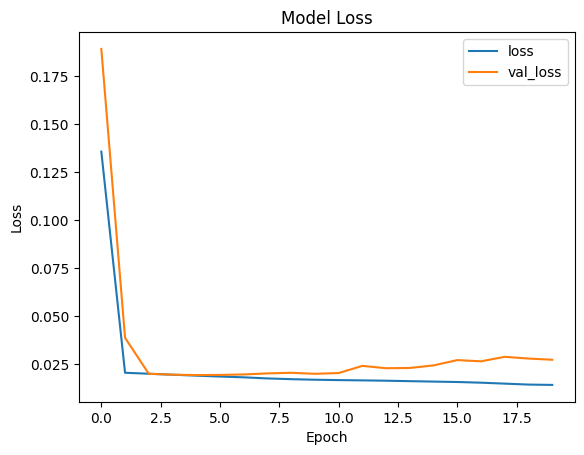

1/1 - 0s - 446ms/step - binary_io_u_3: 0.9451 - loss: 0.0272
Test accuracy: 0.9450562000274658


In [25]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(loc='upper right')
plt.show()


test_loss, test_acc = densenet_model.evaluate(x_test, y_test,verbose=2,)

print(f'Test accuracy: {test_acc}')